In [1]:
# plotting
import matplotlib.pyplot as plt

# arrays and math
import numpy as np

# image processing
import cv2

# opening files and paths
import os

from shapely_conversion import convert
from shapely_utilities import *

import spiral as S
from spiral import calculate_point, calculate_point_contour

import fermat_spiral as FS

# optimization module
from optimization import optimization

import time

In [2]:
'''
Plot a single path
'''
def plot_path(path, color=None):
    
    X = []
    Y = []

    for p in path:
        X.append(p[0])
        Y.append(p[1])
        
    plt.plot(X,Y,c=color)


'''
Plot a list of paths
'''
def plot_recursive_path(total_path, color=None):
    
    rest = []
    
    for path in total_path:
        if type(path) is list:
            plot_path(path, color)
            if path:
                pyplot.scatter(path[0][0], path[0][1], c='green')
                pyplot.scatter(path[-1][0], path[-1][1], c='red')
        else:
            rest.append(path)
            
    plot_path(rest, color)

In [3]:
# this generates the total path without combining the paths
def generate_total_path(result, distance):
    
    total_path = []
    contour_family = []
    
    # loop through each value in the result
    for branch in result:
        if type(branch) is list:  
            total_path.extend(generate_total_path(branch, distance))
        else:
            contour_family.append(branch)

    results = S.generate_path(contour_family, distance)

    total_path.append(results)

    return total_path

In [4]:
# this generates the total path without combining the paths
def generate_total_pathf(result, distance):
    
    total_path = []
    contour_family = []
    
    # loop through each value in the result
    for branch in result:
        if type(branch) is list:  
            total_path.extend(generate_total_pathf(branch, distance))
        else:
            contour_family.append(branch)

    s_path = S.execute(contour_family, distance)
            
    results = FS.convert_fermat(s_path,distance)

    total_path.append(results)

    return total_path

In [5]:
# this creates a fermat path recursively from a tree of Polygon objects
def generate_fermat_path(result, distance):
    
    branches = []

    contour_family = []

    # loop through each node or branch in the tree
    for node in result:
        
        # if the result node is a branch, recursively call this function on it
        if type(node) is list:
            branches.append(generate_fermat_path(node, distance))
        # if the result node is not a branch, add it to the contour family
        else:
            contour_family.append(node)

    # generate the fermat spiral from the root and the branches
    # check that the length of the path is correct
    
    spiral = S.execute(contour_family, distance)     
    root = FS.convert_fermat(spiral,distance)
    
    # combine the root and the branches
    if root:
        return FS.combine_paths(root, branches, distance)
    
    # if there is no root (not sure how this happens but it does) - just return the branches?
    else:
        print("BRANCHES", len(branches))
        return branches

In [6]:
# execute runs the path function "fnc" on an image
# - use this to generate the path from an image
def execute(image, distance, fnc, optimize=False):
    
    opt_reg=1
    opt_smh=10
    opt_spacing=1
    
    total_path = []
    
    start = time.time()
    
    # create the polygons from the image
    polygons = convert(image, approximation = cv2.CHAIN_APPROX_SIMPLE)
    
    print("Polygon:", time.time()-start)
    
    formatted_polygons = []
    
    # each individual polygon should be a separate distinct polygon in the image
    for polygon in polygons:
        
        '''
        Simplify the polygon first (all exterior and interiors)
        '''
        if optimize:
            
            optimize_time = time.time()
            s = list(sample(polygon.exterior,distance).coords)
            
            if len(s) > 5:
                ext = optimization(s, opt_reg, opt_smh, opt_spacing, False)

                ints = []

                for interior in polygon.interiors:
                    i = list(sample(interior,distance).coords)
            
                    if len(i) > 5:
                        ints.append(optimization(i, opt_reg, opt_smh, opt_spacing, False))

                polygon = Polygon(ext, holes=ints)

                print("\tOptimize:", time.time()-optimize_time)
                
                # simplify the shape
                polygon = polygon.simplify(0.5)

        else:
            polygon = polygon.simplify(0.5)
            print(polygon.type)
        
        formatted_polygons.append(polygon)
        
        
        dt_time = time.time()
        # generate the distance transform for the polygon
        result = distance_transform(polygon, -distance)
        
        print("\tDistance Transform:", time.time()-dt_time)
        print(simplify_tree(result))
        path_time = time.time()
        
        # if there is a result, run the path generation function on the result
        if result:
            if fnc == generate_fermat_path:
                total_path.extend(fnc(result, distance))
            else:
                total_path.extend(fnc(result, distance))

            
        print("\tPath:", time.time()-path_time)
    
    print("Total:", time.time()-start)
    
    return total_path, formatted_polygons

In [7]:
%reload_ext autoreload
%autoreload 2

In [8]:
%%time
%matplotlib notebook
'''
This cell runs the complete pipeline from image to CFS output
'''

# distance in between each contour
distance = 1

# filename of image to process
filename = 'files/test_pic.png'

# image should be in binary format
image = cv2.imread(filename,0)

print(not image is None)

# generate the un-connected fermat spiral output
# settings: simplify - True, optimize - False (flip this to true to see effect), optimize locally - True
#           penalize points for moving away from their original position: 1
#           penalize points for violating mid-point scheme: 5
#           spacing penalization is not implemented yet. The last term means nothing for now
# results = execute(image, distance, generate_total_pathf, False)
# plot_recursive_path(results)


True
CPU times: user 7.19 ms, sys: 2.98 ms, total: 10.2 ms
Wall time: 9.43 ms


In [9]:
polygons = convert(image, approximation = cv2.CHAIN_APPROX_SIMPLE)

polygons = [p.simplify(0.5) for p in polygons]

In [11]:
results = S.execute(polygons, 2)

<IPython.core.display.Javascript object>


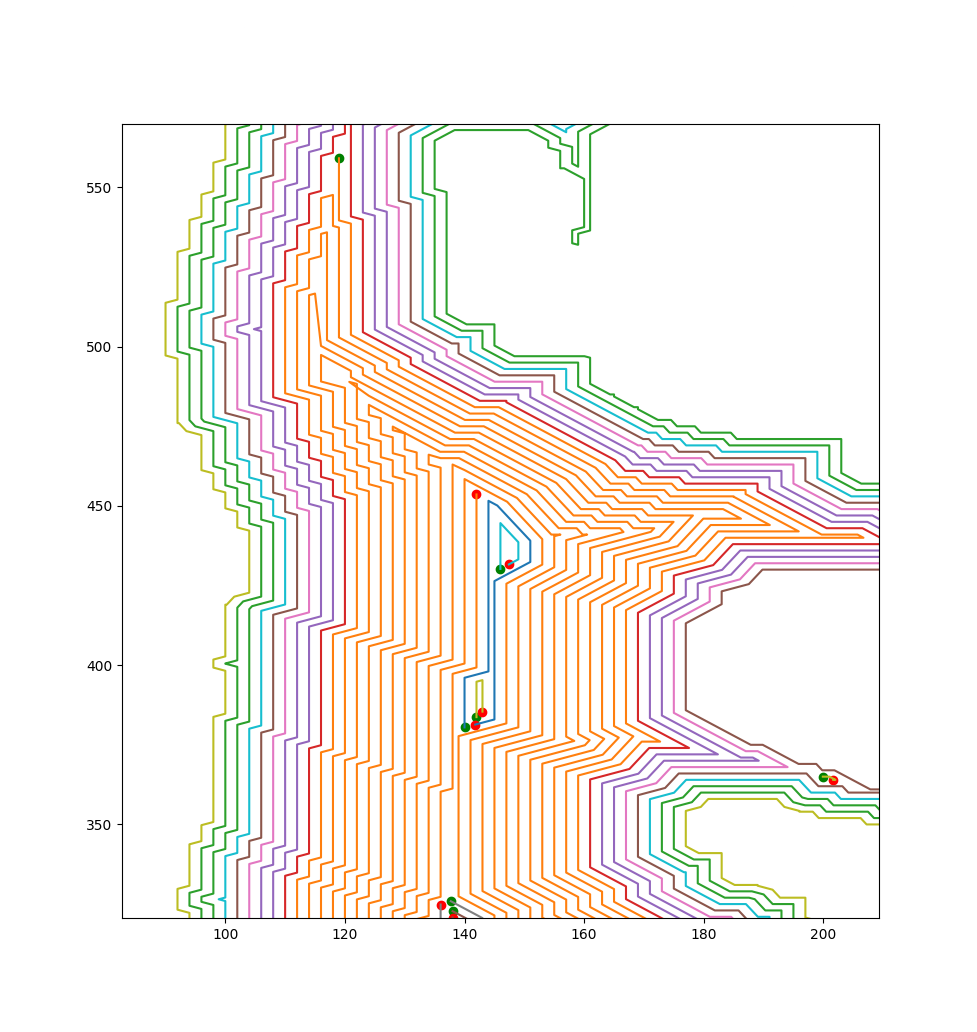

In [12]:
plot_recursive_path(results)

Polygon: 0.008791208267211914
	Distance Transform: 4.458427429199219e-05
	Path: 4.76837158203125e-07
	Distance Transform: 4.601478576660156e-05
	Path: 4.76837158203125e-07
	Optimize: 0.013829469680786133
	Distance Transform: 3.838539123535156e-05
	Path: 2.384185791015625e-07
	Optimize: 0.01094961166381836
	Distance Transform: 3.886222839355469e-05
	Path: 7.152557373046875e-07
	Optimize: 0.013189554214477539
	Distance Transform: 0.00011038780212402344
	Path: 7.152557373046875e-07
	Optimize: 0.01367330551147461
	Distance Transform: 0.0003669261932373047
	Path: 0.004052162170410156
	Distance Transform: 2.956390380859375e-05
	Path: 4.76837158203125e-07
	Optimize: 0.3686203956604004
	Distance Transform: 0.009160757064819336
	Path: 0.1383216381072998
Total: 0.5911290645599365


<IPython.core.display.Javascript object>


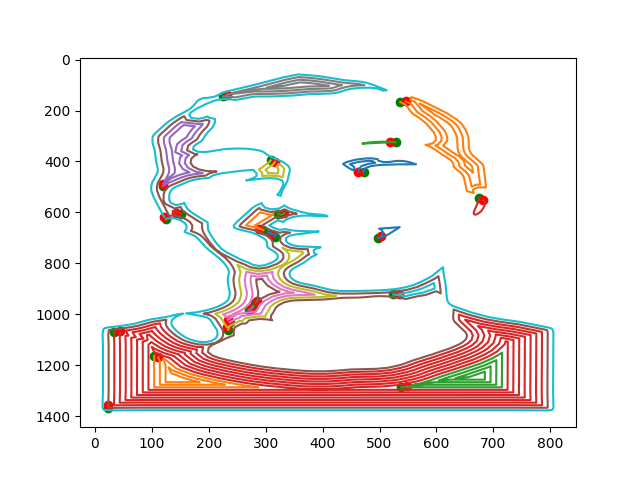

In [194]:

results, polygons = execute(image, distance, generate_total_pathf, True)
    
plot_recursive_path(results)
plt.gca().invert_yaxis()
plt.show()

In [213]:
# helper function to display the format of the "result" tree
# - the "result" tree is the representation of the distance transform 
# - EX: A tree of "['X','X','X', ['X',['X','X'], ['X']], ['X']]" has...
# 1. Three successive outer contours (no branches)
# 2. A branch with a single contour with a depth-2 branch and a depth-1 branch
# 3. A branch with a single contour

# TODO there is probably a better way to set up the trees in this scenario
def simplify_tree(result):
    
    root = []
    output = []
    for b in result:
        if type(b) is list:
            
            if not b:
                print("EMPTY!")
            output.append(simplify_tree(b))
            
    return ["X"] + output

In [214]:
type(result[-1][-1])

tuple

In [268]:
%%time

distance = 10
result, polygons = execute(image, distance, generate_total_path, True)

# format the result


Polygon: 0.008442163467407227
	Distance Transform: 4.1961669921875e-05
['X']
	Path: 4.76837158203125e-07
	Distance Transform: 2.7418136596679688e-05
['X']
	Path: 7.152557373046875e-07
	Optimize: 0.01250147819519043
	Distance Transform: 5.507469177246094e-05
['X']
	Path: 4.76837158203125e-07
	Optimize: 0.012086629867553711
	Distance Transform: 3.814697265625e-05
['X']
	Path: 4.76837158203125e-07
	Optimize: 0.013044595718383789
	Distance Transform: 0.0001373291015625
['X']
	Path: 4.76837158203125e-07
	Optimize: 0.014982461929321289
	Distance Transform: 0.000347137451171875
['X']


AttributeError: module 'spiral_path' has no attribute 'generate_path'

In [253]:
print(simplify_tree(result))

format_result = recursive(result)

print(simplify_tree(format_result))

['X', ['X'], ['X'], ['X'], ['X'], ['X']]
44
['X', ['X'], ['X'], ['X'], ['X'], ['X'], ['X']]


In [262]:
for r in format_result:
    print(len(r))

1401
12
124
7
17
44


In [252]:
def recursive(path):
    
    total_path = []
    rest = []
    
    for p in path:
        if type(p) == list:
            if type(p[0]) == tuple:
                total_path.append(p)
            else:
                total_path.extend(recursive(p))
        else:
            rest.append(p)
            
    print(len(rest))
    
    total_path.append(rest)
    return total_path
                
    

<IPython.core.display.Javascript object>


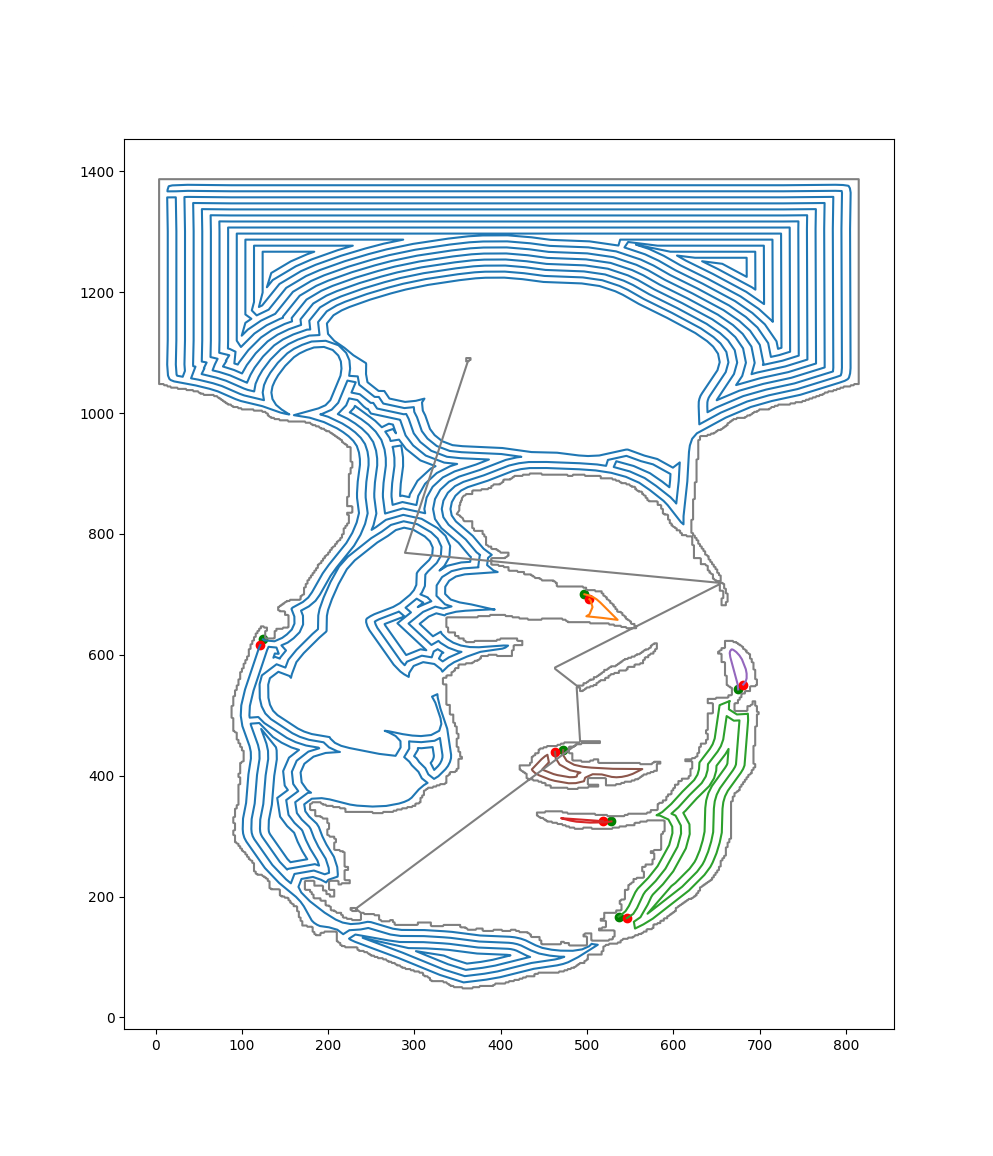

In [263]:
plot_recursive_path(format_result)

In [173]:
%%time

distance = 2
result, polygons = execute(image, distance, generate_fermat_path, False)

print(len(result[0]))

Polygon: 0.0023221969604492188
Polygon
	Distance Transform: 0.015053749084472656
	Path: 7.6687171459198
Total: 7.690294027328491
5398
CPU times: user 7.7 s, sys: 0 ns, total: 7.7 s
Wall time: 7.69 s


In [175]:
def recursive(path):
    
    
    for p in path:
        if p:
            if type(p[0]) == tuple:
                plot_path(p)
            else:
                recursive(p)
    

intersections 0


<IPython.core.display.Javascript object>


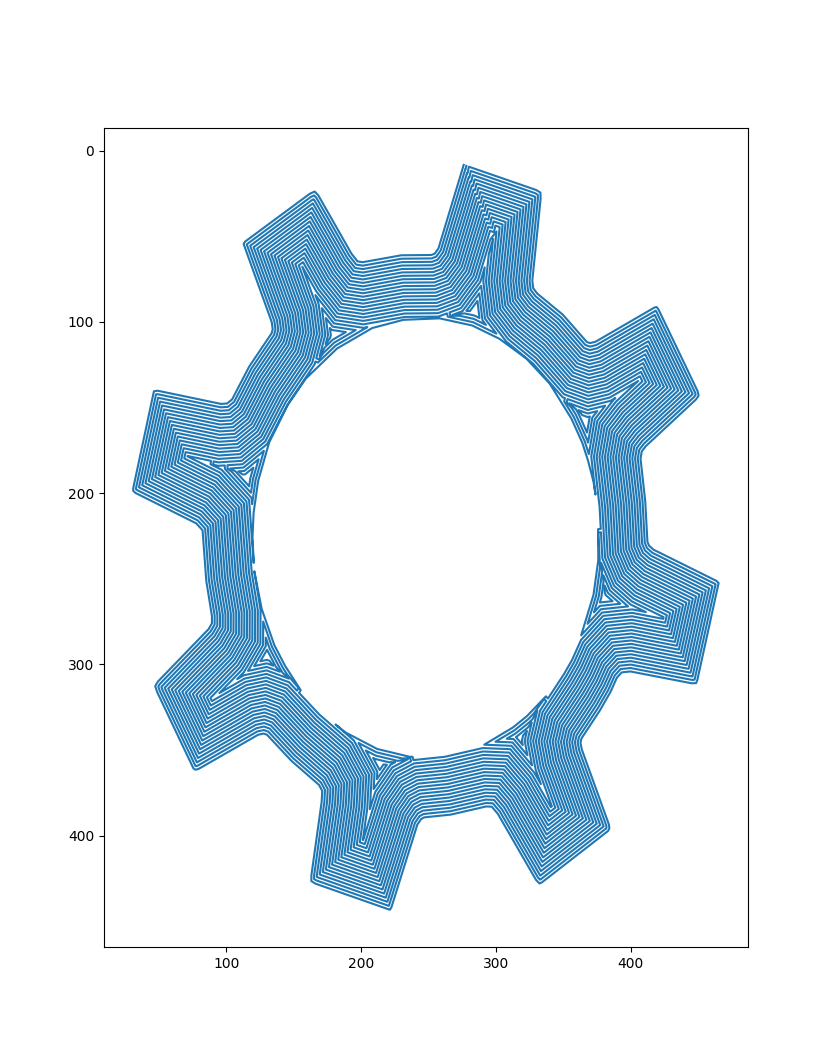

In [176]:
%matplotlib notebook

test = LineString(result[0])

intersections = self_intersections_binary(test)

print("intersections", len(intersections))

for i in intersections:
    pyplot.scatter(i.x,i.y)
    print(i.x,i.y)

recursive(result)
pyplot.gca().invert_yaxis()

In [168]:
from metrics import Metrics

measurer = Metrics(segments=True, commands=True, curvature=False, fill=True)

In [169]:
measurer.measure(result[0], "CFS", distance, polygons)

AssertionError: 

In [140]:
path_areas = [LineString(path).buffer(distance/2+0.001) for path in result[0]]

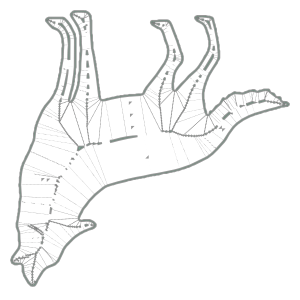

In [141]:
MultiPolygon(polygons).difference(MultiPolygon(path_areas))

In [112]:
MultiPolygon(path_areas).difference(MultiPolygon(polygons))

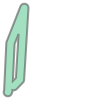

In [80]:
p = LineString(results[0]).buffer(distance/2)
p

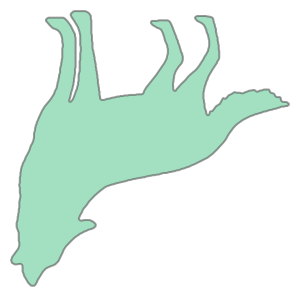

In [84]:
from shapely.geometry import MultiPolygon
MultiPolygon(polygons)

In [53]:
from x import y

ModuleNotFoundError: No module named 'x'

In [ ]:

from gcode import GcodeWriter

In [ ]:
gc = GcodeWriter(filename='wolf.gcode', scale = 0.1)

gc.convert([results])

In [ ]:
LineString()

In [ ]:
polygon = convert(image, 5)[0]

In [ ]:
ls = polygon.exterior


opt_reg = 1
opt_smh = 200
opt_spacing = 1
opt_local = True


# test optimization on input image
opt = optimization(list(ls.coords), opt_reg, opt_smh, opt_spacing, False)

#plot_path(list(ls.coords))
plot_path(opt)

In [ ]:
# test optimization on advanced image
# test optimization on input image
opt = optimization(list(sample(ls,3).coords), opt_reg, opt_smh, opt_spacing, False)

#plot_path(list(ls.coords))
plot_path(opt)

In [ ]:
LineString(results).is_simple

In [ ]:
def remove_short_paths(temp_path, length=20):
    
    clean_path = []
    
    for path in temp_path:
        
        if LineString(path).length > length:
            clean_path.append(path)
    
    return clean_path